In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [3]:
train_path = "dataset/train"
test_path = "dataset/test"

class_labels = {
    "Baroque paintings": 0,
    "Medieval art": 1,
    "Renaissance paintings": 2
}

print("Classes:", class_labels)

Classes: {'Baroque paintings': 0, 'Medieval art': 1, 'Renaissance paintings': 2}


In [4]:
def load_dataset(folder_path):
    X = []
    y = []

    for class_name, label in class_labels.items():
        class_folder = os.path.join(folder_path, class_name)
        print("Processing:", class_folder)

        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)

            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (128, 128))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            features = hog(
                gray,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm="L2-Hys"
            )

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

In [5]:
X_train, y_train = load_dataset(train_path)
X_test, y_test = load_dataset(test_path)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Processing: dataset/train\Baroque paintings
Processing: dataset/train\Medieval art
Processing: dataset/train\Renaissance paintings
Processing: dataset/test\Baroque paintings
Processing: dataset/test\Medieval art
Processing: dataset/test\Renaissance paintings
Train set: (305, 8100) (305,)
Test set: (147, 8100) (147,)


In [6]:
svm_model = SVC(kernel="linear", probability=True)

print("Training SVM model...")
svm_model.fit(X_train, y_train)

print("Training complete!")

Training SVM model...
Training complete!



=== CLASSIFICATION REPORT ===
                       precision    recall  f1-score   support

    Baroque paintings       0.66      0.57      0.61        58
         Medieval art       0.69      0.77      0.73        52
Renaissance paintings       0.46      0.49      0.47        37

             accuracy                           0.62       147
            macro avg       0.60      0.61      0.60       147
         weighted avg       0.62      0.62      0.62       147


=== CONFUSION MATRIX ===
[[33 10 15]
 [ 6 40  6]
 [11  8 18]]


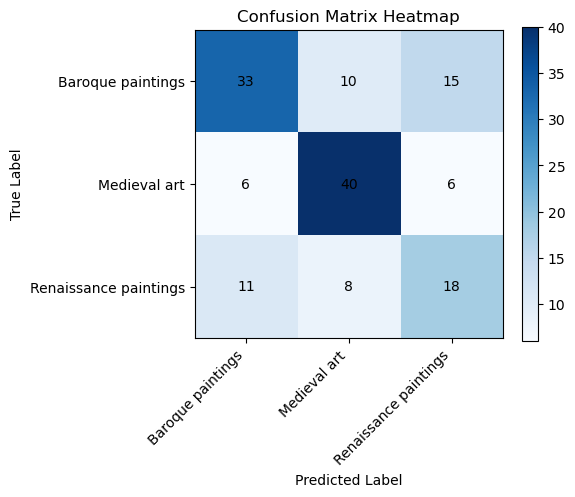

In [ ]:
y_pred = svm_model.predict(X_test)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=class_labels.keys()))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.colorbar()

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks(np.arange(len(class_labels)), list(class_labels.keys()), rotation=45, ha="right")
plt.yticks(np.arange(len(class_labels)), list(class_labels.keys()))

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


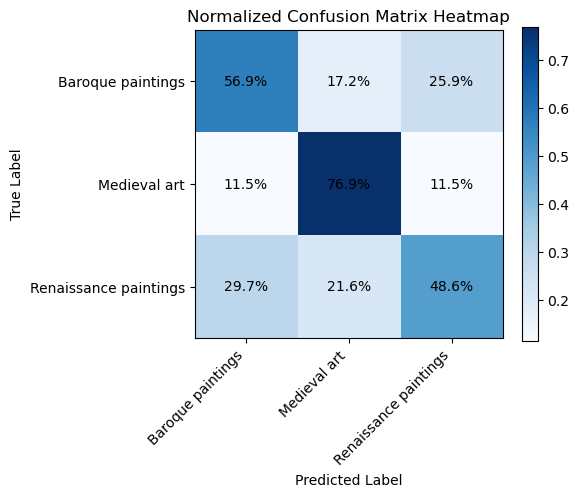

In [ ]:
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation='nearest', cmap='Blues')
plt.title("Normalized Confusion Matrix Heatmap")
plt.colorbar()

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks(np.arange(len(class_labels)), list(class_labels.keys()), rotation=45, ha="right")
plt.yticks(np.arange(len(class_labels)), list(class_labels.keys()))

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]*100:.1f}%",
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

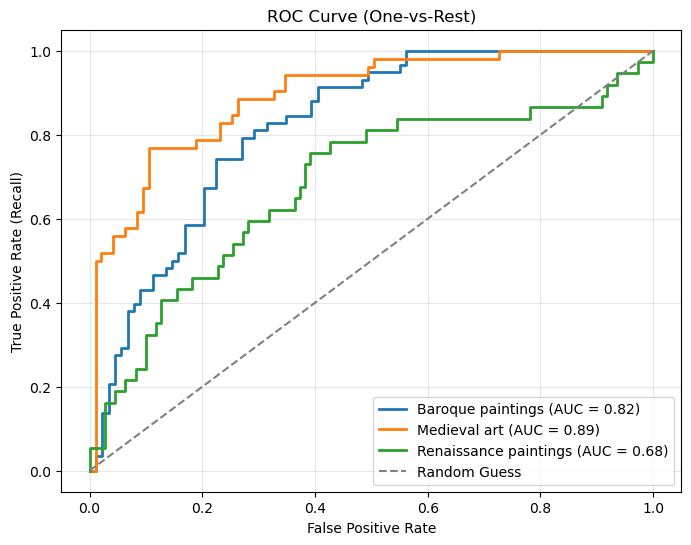

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

y_test_bin = label_binarize(y_test, classes=list(class_labels.values()))
n_classes = y_test_bin.shape[1]

y_score = svm_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names_list = list(class_labels.keys())

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        lw=2,
        label=f"{class_names_list[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], "--", color="gray", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()


In [19]:
joblib.dump(svm_model, "painting_era_hog_svm.pkl")
print("Model saved as painting_era_hog_svm.pkl")

Model saved as painting_era_hog_svm.pkl


In [20]:
def predict_image(img):
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    ).reshape(1, -1)

    pred = svm_model.predict(features)[0]
    probs = svm_model.predict_proba(features)[0]

    inv_map = {v: k for k, v in class_labels.items()}

    return inv_map[pred], probs